# Mean-Shift Clustering on Hypersphere

This repository contains a R script implements von Meses-Fisher (vMF) mean shift clustering [1]. <br> 
vMF mean shift clusteirng is a mean shift clustering on hypersphere (, i.e. this algorithm uses cosine distance).

In [1]:
source("meanshift.R")

library(MeanShift)
library(mclust)

Loading required package: foreach
Loading required package: iterators
Loading required package: parallel
Loading required package: wavethresh
Loading required package: MASS
WaveThresh: R wavelet software, release 4.6.8, installed

Copyright Guy Nason and others 1993-2016

Note: nlevels has been renamed to nlevelsWT

Package 'mclust' version 5.3
Type 'citation("mclust")' for citing this R package in publications.


# Example: Unit Circle

## Data Creation

In [2]:
set.seed(1)
N <- 500
M <- 8
true_labels <- sample(seq_len(M), N, replace=TRUE)
radians <- true_labels / M * 2 * pi + rnorm(N)*0.1
X <- cbind(cos(radians), sin(radians))

## Mean Shift clustering

In [3]:
X_n <- t(X) / apply(t(X), 1, sd )
dist_X_n <- dist(t(X_n))
h.cand <- quantile(dist_X_n, seq( 0.05, 0.40, by=0.05 ) )
# Choose parameters via optimizing silhouette index.
suppressMessages({bms_result <- optimize_silhouette(X_n, data.frame(h=h.cand), dist=dist_X_n, cluster_func=function(X, h){ bmsClustering(X, h=h)})})

## vMF mean shift clustering

In [4]:
# Choose parameters via optimizing silhouette index.
dmatrix <- 1 - cos_similarity_matrix(X, X, 1)
result <- optimize_silhouette(X, data.frame(k=c(0.5,0.6,0.7,0.8,0.9)),  cluster_func=ms_sphere, dmatrix=dmatrix, max_iter=100, convergence_threshold=1e-5, merge_threshold=0.99)

## Results

The results of vMF mean shift and normal mean shift almost the same. vMF is slightly closer to a true cluster.

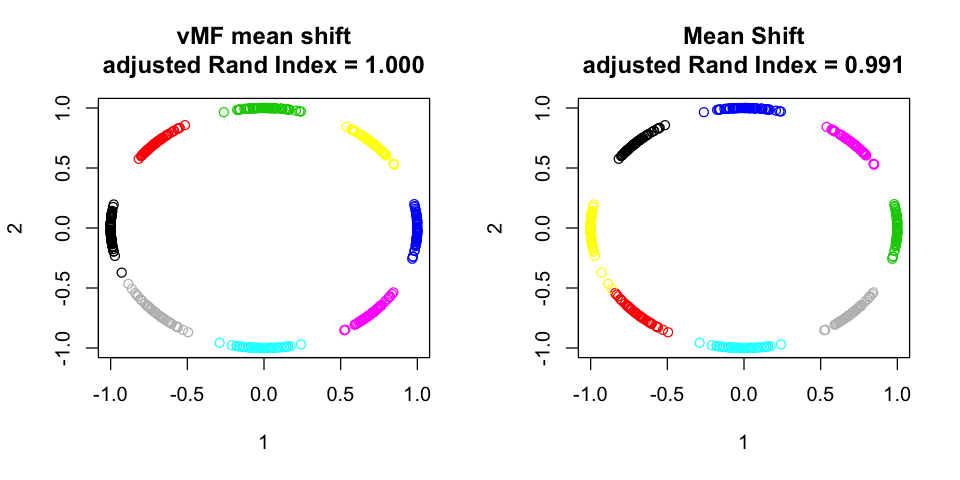

In [5]:
options(repr.plot.width=8, repr.plot.height=4)
par(mfrow=c(1,2))
plot(X, col=result$best$labels, xlab="1", ylab="2", main=sprintf("vMF mean shift\nadjusted Rand Index = %.3f", adjustedRandIndex(true_labels, result$best$labels)))
plot(X, col=bms_result$best$labels, xlab="1", ylab="2", main=sprintf("Mean Shift\nadjusted Rand Index = %.3f", adjustedRandIndex(true_labels, bms_result$best$labels)))

# Example: Unit Sphere

## Data Creation

In [6]:
set.seed(3)
truth <- make_random_clusters(n=500, m=10, d=3, k=50)
X <- truth$X
true_labels <- truth$label

## Mean shift clustering

In [7]:
X_n <- t(X) / apply(t(X), 1, sd )
dist_X_n <- dist(t(X_n))
h.cand <- quantile(dist_X_n, seq( 0.05, 0.40, by=0.05 ) )
# Choose parameters via optimizing silhouette index.
suppressMessages({bms_result <- optimize_silhouette(X_n, data.frame(h=h.cand), dist=dist_X_n, cluster_func=function(X, h){ bmsClustering(X, h=h)})})

## vMF mean shift clustering

In [8]:
# Choose parameters via optimizing Silhouette index.
dmatrix <- 1 - cos_similarity_matrix(X, X, 1)
result <- optimize_silhouette(X, data.frame(k=seq(0.5, 0.99, 0.05)),  dmatrix=dmatrix, cluster_func=ms_sphere, max_iter=100, convergence_threshold=1e-5, merge_threshold=0.99)

## Results

The result of vMF mean shift is closer to the true clustering.

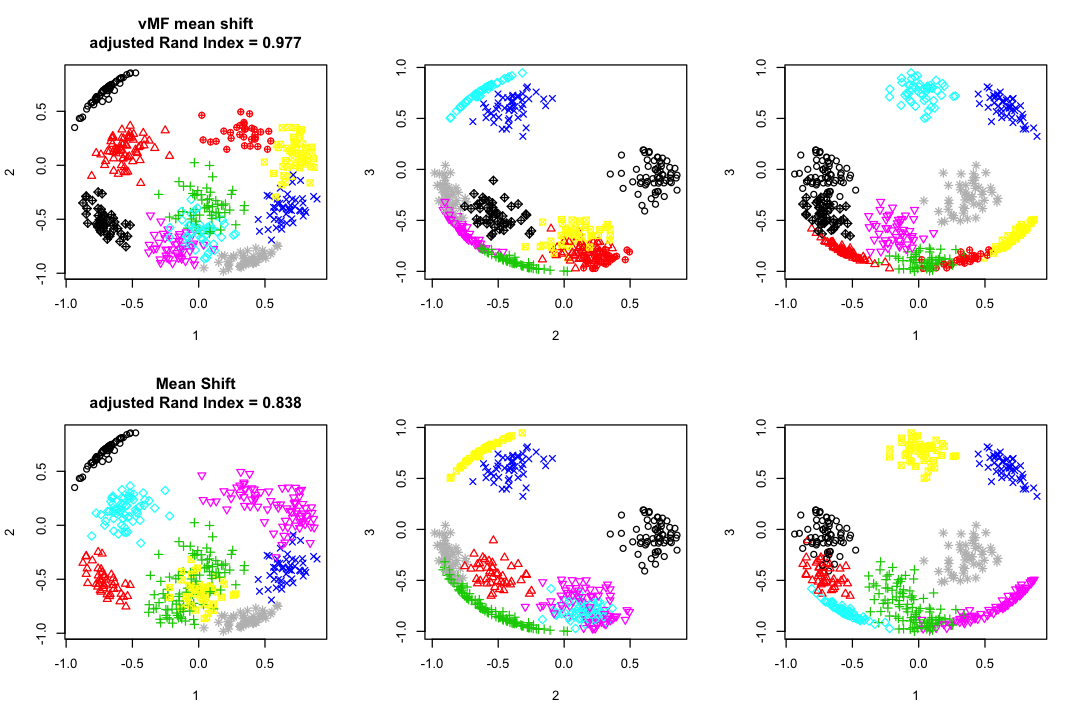

In [9]:
options(repr.plot.width=9, repr.plot.height=6)
par(mfrow=c(2,3))

plot(X[,c(1,2)], col=result$best$labels, pch=result$best$labels, xlab="1", ylab="2", 
     main=sprintf("vMF mean shift\nadjusted Rand Index = %.3f", adjustedRandIndex(true_labels, result$best$labels)))
plot(X[,c(2,3)], col=result$best$labels, pch=result$best$labels, xlab="2", ylab="3")
plot(X[,c(1,3)], col=result$best$labels, pch=result$best$labels, xlab="1", ylab="3")

plot(X[,c(1,2)], col=bms_result$best$labels, pch=bms_result$best$labels, xlab="1", ylab="2", 
     main=sprintf("Mean Shift\nadjusted Rand Index = %.3f", adjustedRandIndex(true_labels, bms_result$best$labels)))
plot(X[,c(2,3)], col=bms_result$best$labels, pch=bms_result$best$labels, xlab="2", ylab="3")
plot(X[,c(1,3)], col=bms_result$best$labels, pch=bms_result$best$labels, xlab="1", ylab="3")

# Compareing Normal and vMF Mean Shift in High Dimensional Sphere

In [10]:
library(foreach)
dims <- seq.int(3,10)
aRIs <- foreach(d = dims, .combine="rbind") %do% {
    #  Create Data
    set.seed(d)
    truth <- make_random_clusters(n=500, m=10, d=d, k=50)
    X <- truth$X
    true_labels <- truth$label
    
    # Mean Shift Clustering
    X_n <- t(X) / apply(t(X), 1, sd )
    dist_X_n <- dist(t(X_n))
    h.cand <- quantile(dist_X_n, seq( 0.05, 0.40, by=0.05 ) )
    # Choose parameters via optimizing silhouette index.
    suppressMessages({bms_result <- optimize_silhouette(X_n, data.frame(h=h.cand), dist=dist_X_n, cluster_func=function(X, h){ bmsClustering(X, h=h)})})
    
    # vMF mean shift
    dmatrix <- 1 - cos_similarity_matrix(X, X, 1)
    result <- optimize_silhouette(X, data.frame(k=seq(0.5, 0.99, 0.05)),  dmatrix=dmatrix, cluster_func=ms_sphere, max_iter=100, convergence_threshold=1e-5, merge_threshold=0.99)
    
    #message(sprintf("dim=%d, aRI= %.3f, %.3f", d, adjustedRandIndex(true_labels, result$best$labels), adjustedRandIndex(true_labels, bms_result$best$labels)))
    return(c(adjustedRandIndex(true_labels, result$best$labels), adjustedRandIndex(true_labels, bms_result$best$labels)))
}
aRIs <- data.frame(dim=dims, aRIs, row.names=NULL)
colnames(aRIs) <- c("dim", "adjusted_Rand_Index_vMF", "adjusted_Rand_Index_Normal")
aRIs

dim,adjusted_Rand_Index_vMF,adjusted_Rand_Index_Normal
3,0.9766475,0.8380781
4,0.6517243,0.4532225
5,0.8203910,0.8203910
6,0.9821823,0.7258188
7,0.7045497,0.6530087
8,0.9958167,0.8060414
9,1.0000000,0.9952599
10,1.0000000,0.7039020


# Benchmark of Very High Dimension and Large Data

In [11]:
set.seed(1)
N <- 10000
M <- 300
X <- l2_normalize(matrix(rnorm(N*M), N, M))

In [12]:
system.time({
    result <- ms_sphere(X, max_iter=100, k=0.9, convergence_threshold=1e-5, merge_threshold=0.99, n_parallel = 8)
})

   user  system elapsed 
475.938  65.111 109.165 

# References

1. T. Kobayashi and N. Otsu, Von Mises-Fisher mean shift for clustering on a hypersphere, ICPR 2010.